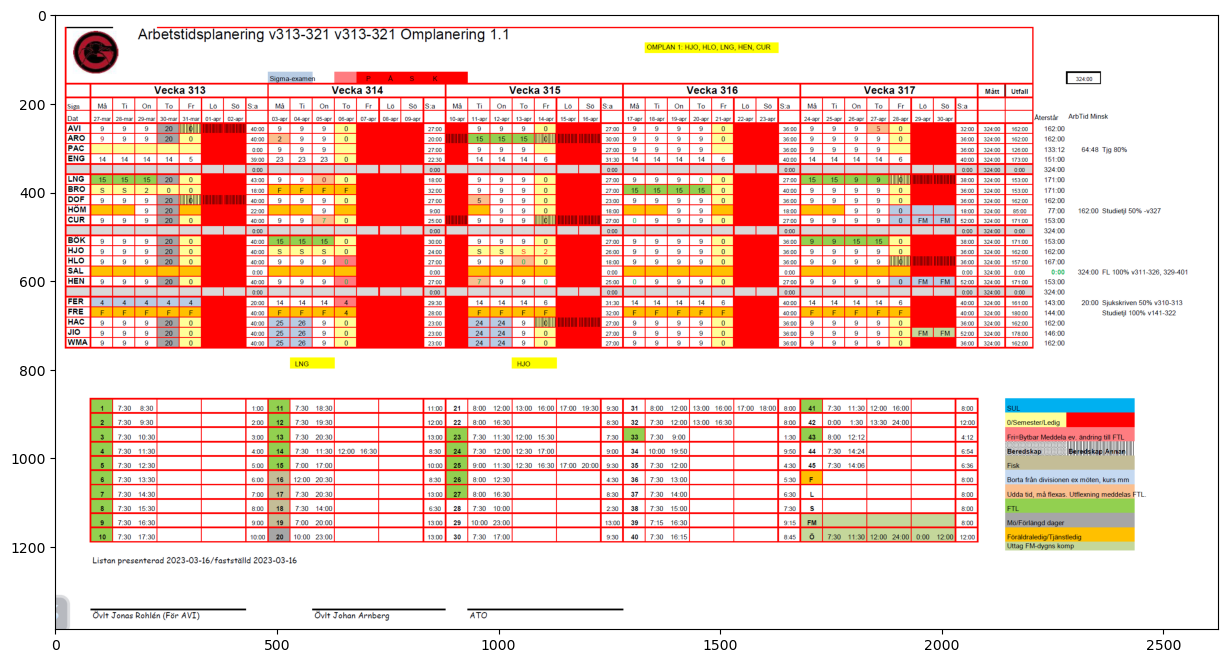

194
117


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_lines(image):
    # Initialize two empty lists to store the horizontal and vertical lines
    horizontal_lines = []
    vertical_lines = []

    # Scan the image for horizontal lines
    for y in range(image.shape[0]):
        white_pixels = []
        for x in range(image.shape[1]):
            if image[y, x] == 255:  # White pixel
                white_pixels.append((x, y))
            elif white_pixels:
                if len(white_pixels) >= 400:
                    horizontal_lines.append(white_pixels)
                white_pixels = []
        if white_pixels and len(white_pixels) >= 400:
            horizontal_lines.append(white_pixels)

    # Scan the image for vertical lines
    for x in range(image.shape[1]):
        white_pixels = []
        for y in range(image.shape[0]):
            if image[y, x] == 255:  # White pixel
                white_pixels.append((x, y))
            elif white_pixels:
                if len(white_pixels) >= 200:
                    vertical_lines.append(white_pixels)
                white_pixels = []
        if white_pixels and len(white_pixels) >= 200:
            vertical_lines.append(white_pixels)

    return horizontal_lines, vertical_lines


# Load the image in full color
color_image = cv2.imread('schema_pic.png', cv2.IMREAD_COLOR)

# Convert the color image to grayscale
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

# Threshold the image to get a binary image
_, binary_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)

# Detect the lines in the image
horizontal_lines, vertical_lines = detect_lines(binary_image)


# Create a copy of the color image to draw the lines on
line_image = np.copy(color_image)

# Draw the lines on the image
for line in horizontal_lines:
    for x, y in line:
        line_image[y, x] = [0, 0, 255]  # Set the color of the line pixels to red

for line in vertical_lines:
    for x, y in line:
        line_image[y, x] = [0, 0, 255]  # Set the color of the line pixels to red

# Display the image with the detected lines
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()

print(len(vertical_lines))
print(len(horizontal_lines))


194
117


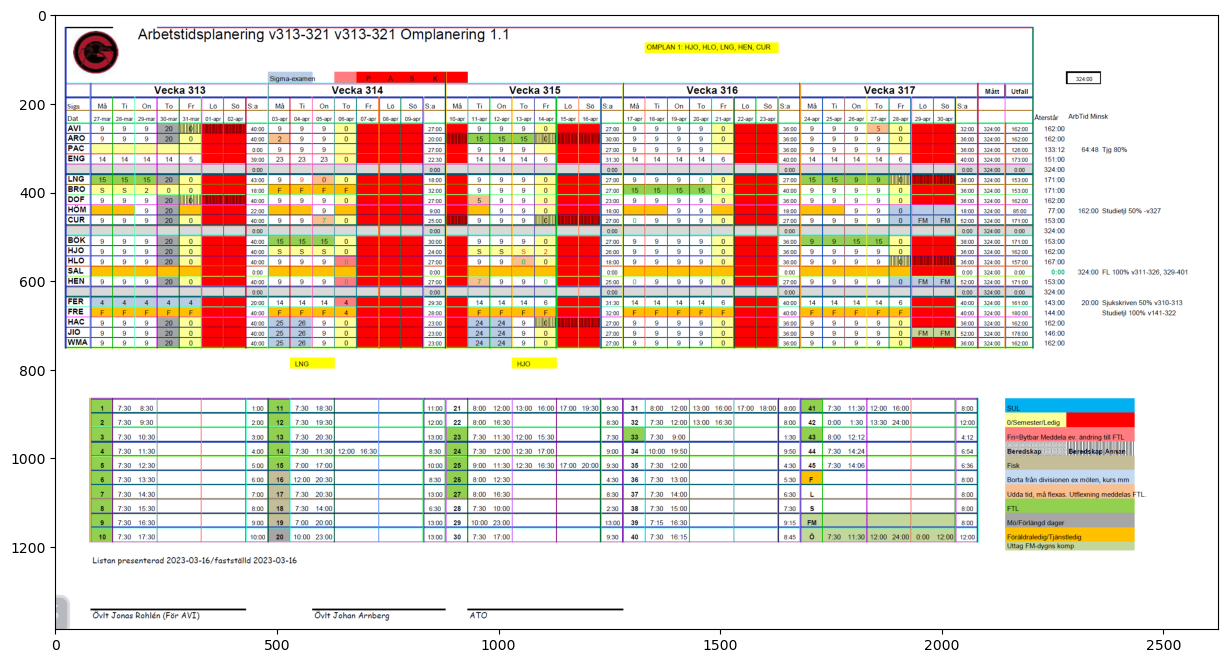

In [4]:
def merge_lines(lines, is_horizontal=True, thickness_threshold=10, length_threshold=10):
    if not lines:
        return []

    # Sorting criterion depends on whether the lines are horizontal or vertical
    sort_index = 1 if is_horizontal else 0
    lines.sort(key=lambda line: (line[0][sort_index], line[0][1-sort_index]))

    merged_lines = []
    current_line = lines[0]

    for next_line in lines[1:]:
        # Check whether the lines are neighboring and part of the same grid line
        if abs(current_line[0][sort_index] - next_line[0][sort_index]) <= thickness_threshold and \
                abs(current_line[-1][1-sort_index] - next_line[0][1-sort_index]) <= thickness_threshold:
            # Merge the lines by taking union of pixels
            current_line = list(set(current_line) | set(next_line))
        else:
            # Only add line if it exceeds the minimum length
            if len(current_line) >= length_threshold:
                merged_lines.append(current_line)
            current_line = next_line

    # Add the last line if it exceeds the minimum length
    if len(current_line) >= length_threshold:
        merged_lines.append(current_line)

    return merged_lines



# Merge the lines
merged_horizontal_lines = merge_lines(horizontal_lines, True)
merged_vertical_lines = merge_lines(vertical_lines, False)

print(len(merged_vertical_lines))  # Print the number of merged lines
print(len(merged_horizontal_lines))  # Print the number of merged lines

# Create a copy of the color image to draw the lines on
line_image1 = np.copy(color_image)

# Draw the lines on the image
# List of 10 different RGB color values
colors = [
    [255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [192, 192, 192],# Silver
    [128, 0, 0],    # Maroon
    [128, 128, 0],  # Olive
    [0, 128, 0],    # Dark Green
]

color_index = 0

for line in merged_horizontal_lines:
    for x, y in line:
        line_image1[y, x] = colors[color_index]  # Set the color of the line pixels
    color_index = (color_index + 1) % len(colors)  # Cycle through the colors

for line in merged_vertical_lines:
    for x, y in line:
        line_image1[y, x] = colors[color_index]  # Set the color of the line pixels
    color_index = (color_index + 1) % len(colors)  # Cycle through the colors

# Display the image with the detected lines
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(line_image1, cv2.COLOR_BGR2RGB))
plt.show()


In [5]:
def get_cells(horizontal_lines, vertical_lines):
    # Flatten the list of lines and separate the x and y coordinates
    x_coords = {x for line in vertical_lines for x, _ in line}
    y_coords = {y for line in horizontal_lines for _, y in line}

    # Convert the sets to sorted lists
    x_coords = sorted(list(x_coords))
    y_coords = sorted(list(y_coords))

    # Get the cells by finding the four corners for each consecutive pair of x and y coordinates
    cells = []
    for i in range(len(x_coords) - 1):
        for j in range(len(y_coords) - 1):
            cell = [(x_coords[i], y_coords[j]),
                    (x_coords[i+1], y_coords[j]),
                    (x_coords[i], y_coords[j+1]),
                    (x_coords[i+1], y_coords[j+1])]
            cells.append(cell)

    return cells

cells = get_cells(merged_horizontal_lines, merged_vertical_lines)
len(cells)

14036

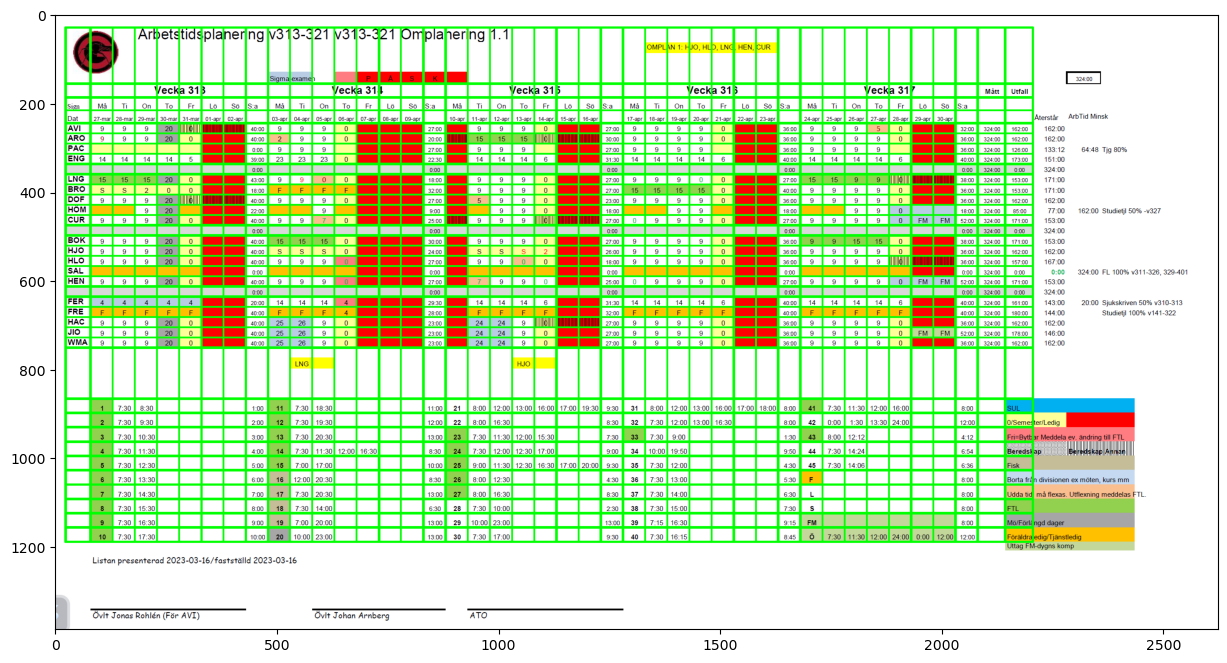

In [6]:
# Create a copy of the original image
image_with_cells = np.copy(color_image)

# Draw rectangles around each cell
for cell in cells:
    # OpenCV's rectangle function takes two points: the top-left and bottom-right corners of the rectangle
    top_left = cell[0]
    bottom_right = cell[3]
    cv2.rectangle(image_with_cells, top_left, bottom_right, [0, 255, 0], 2)

# Display the image with the cells highlighted
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB))
plt.show()


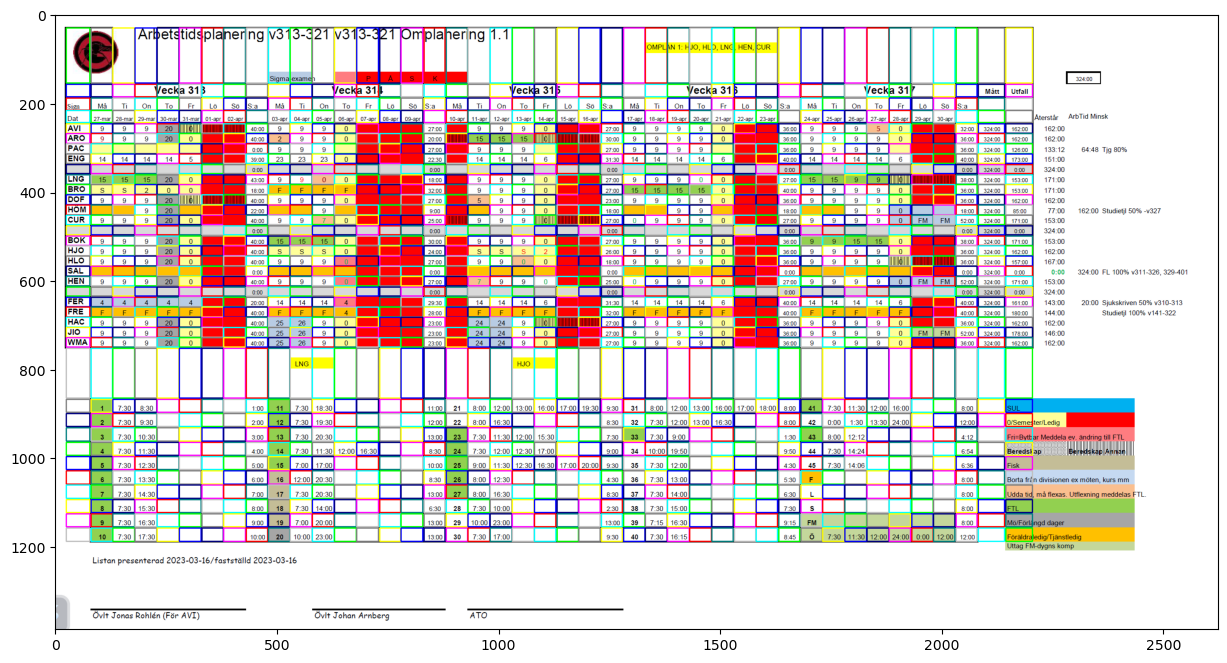

1591

In [7]:
def filter_cells_by_dimensions(cells, min_width=20, min_height=20):
    filtered_cells = []

    for cell in cells:
        # Calculate the width and height of the cell
        width = abs(cell[1][0] - cell[0][0])
        height = abs(cell[2][1] - cell[0][1])

        # Only keep the cell if its width and height are above the specified minimums
        if width >= min_width and height >= min_height:
            filtered_cells.append(cell)

    return filtered_cells

cells_filtered = filter_cells_by_dimensions(cells, 10, 10)


image_with_cells = np.copy(color_image)



# List of colors for the rectangles
colors = [[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255], [192, 192, 192], [128, 128, 128], [128, 0, 0], [128, 128, 0]]

# Create a copy of the original image
image_with_cells = color_image.copy()

# Draw rectangles around each cell
for i, cell in enumerate(cells_filtered):
    # OpenCV's rectangle function takes two points: the top-left and bottom-right corners of the rectangle
    top_left = cell[0]
    bottom_right = cell[3]
    # Use different colors for the rectangles
    color = colors[i % len(colors)]
    cv2.rectangle(image_with_cells, top_left, bottom_right, color, 2)

# Display the image with the cells highlighted
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(image_with_cells, cv2.COLOR_BGR2RGB))
plt.show()


len(cells_filtered)

In [8]:
cells_filtered

[[(25, 31), (78, 31), (25, 155), (78, 155)],
 [(25, 158), (78, 158), (25, 186), (78, 186)],
 [(25, 189), (78, 189), (25, 216), (78, 216)],
 [(25, 217), (78, 217), (25, 244), (78, 244)],
 [(25, 247), (78, 247), (25, 268), (78, 268)],
 [(25, 269), (78, 269), (25, 291), (78, 291)],
 [(25, 292), (78, 292), (25, 314), (78, 314)],
 [(25, 315), (78, 315), (25, 336), (78, 336)],
 [(25, 339), (78, 339), (25, 359), (78, 359)],
 [(25, 362), (78, 362), (25, 383), (78, 383)],
 [(25, 384), (78, 384), (25, 406), (78, 406)],
 [(25, 407), (78, 407), (25, 429), (78, 429)],
 [(25, 430), (78, 430), (25, 452), (78, 452)],
 [(25, 453), (78, 453), (25, 474), (78, 474)],
 [(25, 477), (78, 477), (25, 497), (78, 497)],
 [(25, 500), (78, 500), (25, 521), (78, 521)],
 [(25, 522), (78, 522), (25, 544), (78, 544)],
 [(25, 545), (78, 545), (25, 567), (78, 567)],
 [(25, 568), (78, 568), (25, 590), (78, 590)],
 [(25, 591), (78, 591), (25, 612), (78, 612)],
 [(25, 615), (78, 615), (25, 635), (78, 635)],
 [(25, 638), (7

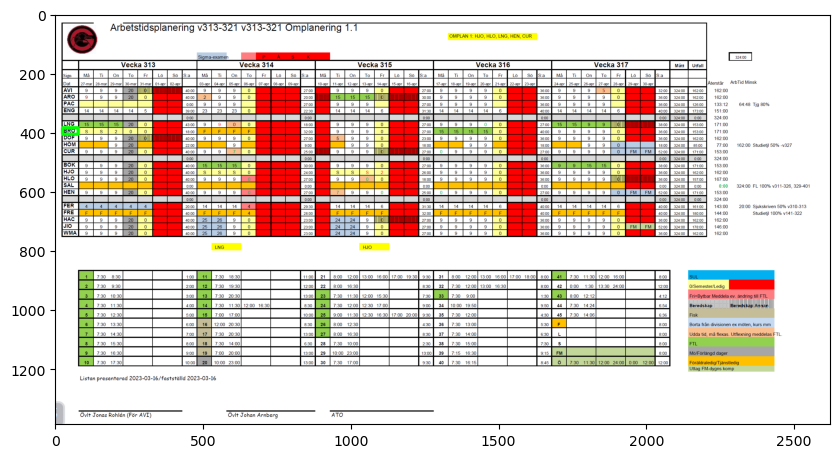

In [9]:
 # Create a copy of the image to avoid modifying the original
image_copy = color_image.copy()
cell = cells_filtered[10]
# OpenCV's rectangle function takes two points: the top-left and bottom-right corners of the rectangle
top_left = cell[0]
bottom_right = cell[3]
cv2.rectangle(image_copy, top_left, bottom_right, color, 10)

# Display the image with the cell highlighted
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:

def rescale_image(image, new_height=35):
    # Get the current dimensions of the image
    original_height, original_width = image.shape[:2]

    # Calculate the new width while maintaining the aspect ratio
    new_width = int(original_width * new_height / original_height)

    # Use cv2.resize to resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

    return resized_image

def crop_borders(image, x):
    """
    Crop the left and top border of an image.

    :param image: numpy array
        The input image.
    :param x: int
        The number of pixels to crop from the left and top border.

    :return: numpy array
        The cropped image.
    """
    height, width = image.shape[:2]
    return image[x:height-x, x:width-x]

def is_cell_empty(image, variance_threshold=2000):
    """
    Check if a cell is more or less empty.

    :param image: numpy array
        The input image.
    :param variance_threshold: int
        The threshold for variance to consider a cell as empty.

    :return: boolean
        True if the cell is empty, False otherwise.
    """
    #The threshold 2000 is usally enough for an empty cell
    return np.var(image) < variance_threshold

def move_cell(cell, direction, move_pixels=5):
    """
    Move the boundaries of a cell in a certain direction by a certain number of pixels.

    :param cell: list
        The cell boundaries in the format [top_left, top_right, bottom_left, bottom_right].
    :param direction: str
        The direction to move the cell's boundaries. Can be 'left', 'up', 'right', or 'down'.
    :param move_pixels: int
        The number of pixels to move the cell's boundaries.

    :return: list
        The new cell.
    """
    # Get the cell's boundaries
    top_left = list(cell[0])
    bottom_right = list(cell[3])

    # Determine the direction to move the cell's boundaries
    if direction == 'left':
        top_left[0] -= move_pixels
        bottom_right[0] -= move_pixels
    elif direction == 'up':
        top_left[1] -= move_pixels
        bottom_right[1] -= move_pixels
    elif direction == 'right':
        top_left[0] += move_pixels
        bottom_right[0] += move_pixels
    elif direction == 'down':
        top_left[1] += move_pixels
        bottom_right[1] += move_pixels

    # Return the new cell
    new_cell = [top_left, [bottom_right[0], top_left[1]], [top_left[0], bottom_right[1]], bottom_right]

    return new_cell

import numpy as np

def remove_frame(image, threshold=150):
    while True:
        # Check if the borders are uniformly colored
        top_row = image[0, :]
        bottom_row = image[-1, :]
        left_col = image[:, 0]
        right_col = image[:, -1]

        # If the borders are uniform and in a shade of black, remove them
        if np.all(top_row < threshold):
            image = image[1:, :]
        elif np.all(bottom_row < threshold):
            image = image[:-1, :]
        elif np.all(left_col < threshold):
            image = image[:, 1:]
        elif np.all(right_col < threshold):
            image = image[:, :-1]
        else:
            # If no borders are uniformly colored and in a shade of black, stop the loop
            break

    return image

def remove_border(image, threshold=50):
    while True:
        # Check the mean color of the border pixels, if it's less than the threshold, remove the border
        if np.mean(image[0, :]) < threshold:  # top border
            print(f"Removing top border, mean color: {np.mean(image[0, :])}")
            image = image[1:, :]
        elif np.mean(image[-1, :]) < threshold:  # bottom border
            print(f"Removing bottom border, mean color: {np.mean(image[-1, :])}")
            image = image[:-1, :]
        elif np.mean(image[:, 0]) < threshold:  # left border
            print(f"Removing left border, mean color: {np.mean(image[:, 0])}")
            image = image[:, 1:]
        elif np.mean(image[:, -1]) < threshold:  # right border
            print(f"Removing right border, mean color: {np.mean(image[:, -1])}")
            image = image[:, :-1]
        else:
            # If no border has mean color less than the threshold, break the loop

            break

    return image

def print_image(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap='gray')
    plt.show()

In [11]:
import pytesseract
def read_cell(image, cell, type=None, print = False):
    cell_contents = {}

    # Define cell boundaries
    top_left = cell[0]
    bottom_right = cell[3]
    # Crop the image to the cell's boundaries
    cell_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    #Check if cell is more or less empty

    cell_empty = is_cell_empty(cell_image)
    config = '--psm 7'
    if type == 'digit':
        config= '--psm 10'
    if cell_empty:
        text = 'empty'

    else:
        #cell_image = crop_borders(cell_image,2)
        cell_image = remove_frame(cell_image, 50)

        # Use Tesseract to extract the text from the cell
        text = pytesseract.image_to_string(cell_image, config=config).strip()  # strip() is used to remove leading and trailing white space

        if text == "":
            cell_image = rescale_image(cell_image)
            text = pytesseract.image_to_string(cell_image, config=config).strip()
        directions = ['down', 'up', 'left', 'right']

        for direction in directions:
            if text == "":
                new_cell = move_cell(cell, direction, 10)
                cell_image_moved = image[new_cell[0][1]:new_cell[3][1], new_cell[0][0]:new_cell[3][0]]
                text = pytesseract.image_to_string(cell_image_moved, config=config).strip()
            else:
                break
        if text == "":
            dilated_image = dilate_image(gray_image, cell, 3)
            text = pytesseract.image_to_string(dilated_image, config=config).strip()
        if text == "":
            eroded_image = erode_image(gray_image, cell, 3)
            text = pytesseract.image_to_string(eroded_image, config=config).strip()
        if text == "":
            text = pytesseract.image_to_string(cell_image, config='--psm 10')
            if text == 'oO\n':
                text == ""
        if text == "":
            print('Cant regognize')
            plt.figure(figsize=(5,5))
            plt.imshow(cell_image, cmap='gray')
            plt.show()
            print(cell)

    rect = [top_left, (bottom_right[0], top_left[1]), (top_left[0], bottom_right[1]), bottom_right]
    if print: print_image(cell_image)
    cell_contents = {'rect': rect, 'content': text}
    return cell_contents

cell_contents = read_cell(gray_image, cells_filtered[11])
cell_contents

{'rect': [(25, 407), (78, 407), (25, 429), (78, 429)], 'content': 'DOF'}

In [12]:
# Initialize an empty list to store the contents of all cells
all_cell_contents = []

# Loop over cells 3-26
for i in range(3, 26):
    # Read the cell and append its contents to the list
    cell_contents = read_cell(gray_image, cells_filtered[i])
    all_cell_contents.append(cell_contents)

# Print the contents of all cells
for cell in all_cell_contents:
    print(cell)


{'rect': [(25, 217), (78, 217), (25, 244), (78, 244)], 'content': 'Dat'}
{'rect': [(25, 247), (78, 247), (25, 268), (78, 268)], 'content': 'AVI'}
{'rect': [(25, 269), (78, 269), (25, 291), (78, 291)], 'content': 'ARO'}
{'rect': [(25, 292), (78, 292), (25, 314), (78, 314)], 'content': 'PAC'}
{'rect': [(25, 315), (78, 315), (25, 336), (78, 336)], 'content': 'ENG'}
{'rect': [(25, 339), (78, 339), (25, 359), (78, 359)], 'content': 'a'}
{'rect': [(25, 362), (78, 362), (25, 383), (78, 383)], 'content': 'LNG'}
{'rect': [(25, 384), (78, 384), (25, 406), (78, 406)], 'content': 'BRO'}
{'rect': [(25, 407), (78, 407), (25, 429), (78, 429)], 'content': 'DOF'}
{'rect': [(25, 430), (78, 430), (25, 452), (78, 452)], 'content': 'HOM'}
{'rect': [(25, 453), (78, 453), (25, 474), (78, 474)], 'content': 'CUR'}
{'rect': [(25, 477), (78, 477), (25, 497), (78, 497)], 'content': 'a'}
{'rect': [(25, 500), (78, 500), (25, 521), (78, 521)], 'content': 'BOK'}
{'rect': [(25, 522), (78, 522), (25, 544), (78, 544)], 

In [13]:
'''all_cell_contents = []

# Loop over cells 3-26
for cell in cells_filtered:
    # Read the cell and append its contents to the list
    cell_contents = read_cell(gray_image,cell)
    all_cell_contents.extend(cell_contents)'''

'all_cell_contents = []\n\n# Loop over cells 3-26\nfor cell in cells_filtered:\n    # Read the cell and append its contents to the list\n    cell_contents = read_cell(gray_image,cell)\n    all_cell_contents.extend(cell_contents)'

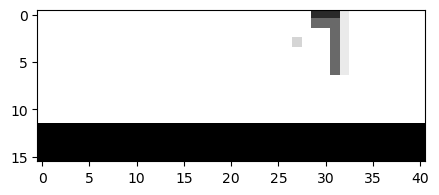

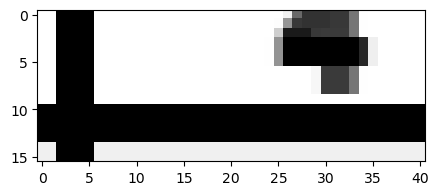

In [14]:
cell_sor = [(276, 648), (317, 648), (276, 664), (317, 664)]
cell_ben = [(276, 719), (317, 719), (276, 734), (317, 734)]

def dilate_image(image, cell, kernel_size=5):
    """
    Dilate the image.

    :param image: numpy array
        The input image.
    :param cell: list
        The cell boundaries in the format [top_left, top_right, bottom_left, bottom_right].
    :param kernel_size: int
        The size of the kernel used for dilation. A larger kernel_size value means a larger dilation effect.

    :return: numpy array
        The dilated image.
    """
    # Get the cell's boundaries
    top_left = cell[0]
    bottom_right = cell[3]

    # Crop the image to the cell's boundaries
    cell_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Create the kernel for dilation
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Dilate the image
    dilated_image = cv2.dilate(cell_image, kernel, iterations = 1)

    return dilated_image

def erode_image(image, cell, kernel_size=5):
    """
    Erode the image.

    :param image: numpy array
        The input image.
    :param cell: list
        The cell boundaries in the format [top_left, top_right, bottom_left, bottom_right].
    :param kernel_size: int
        The size of the kernel used for erosion. A larger kernel_size value means a larger erosion effect.

    :return: numpy array
        The eroded image.
    """
    # Get the cell's boundaries
    top_left = cell[0]
    bottom_right = cell[3]

    # Crop the image to the cell's boundaries
    cell_image = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    # Create the kernel for erosion
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Erode the image
    eroded_image = cv2.erode(cell_image, kernel, iterations = 1)

    return eroded_image

dilated_image = dilate_image(gray_image, cell_sor, 3)

plt.figure(figsize=(5,5))
plt.imshow(dilated_image, cmap='gray')
plt.show()

eroded_image = erode_image(gray_image, cell_sor, 3)
plt.figure(figsize=(5,5))
plt.imshow(eroded_image, cmap='gray')
plt.show()

In [15]:
def get_cells_on_row(all_cells, reference_cell, only_right=False):
    # Get the y-coordinates of the reference cell
    reference_y_top = reference_cell[0][1]
    reference_y_bottom = reference_cell[2][1]

    # Get the x-coordinate of the right edge and left edge of the reference cell
    reference_x_right = reference_cell[2][0]
    reference_x_left = reference_cell[0][0]

    # Initialize an empty list to store the date cells
    row_cells = []

    # Iterate over all cells
    for cell in all_cells:
        # Get the y-coordinates of the current cell
        cell_y_top = cell[0][1]
        cell_y_bottom = cell[2][1]

        # Get the x-coordinate of the left and right edge of the current cell
        cell_x_left = cell[0][0]
        cell_x_right = cell[2][0]

        # Check if any part of the current cell falls within the vertical range of the reference cell
        if not (cell_y_bottom < reference_y_top or cell_y_top > reference_y_bottom):
            # Check if we only want cells on the right or all cells on the same row
            if only_right:
                # Only consider the cell if it is to the right of the reference cell
                if cell_x_left > reference_x_right:
                    row_cells.append(cell)
            else:
                # Consider all cells on the same row
                if cell_x_right < reference_x_left or cell_x_left > reference_x_right:
                    row_cells.append(cell)

    return row_cells

reference_cell = [(25, 217), (78, 217), (25, 244), (78, 244)]  # The cell you provided

date_cells = get_cells_on_row(cells_filtered, reference_cell)
date_cells

[[(81, 217), (129, 217), (81, 244), (129, 244)],
 [(130, 217), (179, 217), (130, 244), (179, 244)],
 [(180, 217), (229, 217), (180, 244), (229, 244)],
 [(230, 217), (279, 217), (230, 244), (279, 244)],
 [(280, 217), (329, 217), (280, 244), (329, 244)],
 [(331, 217), (379, 217), (331, 244), (379, 244)],
 [(380, 217), (429, 217), (380, 244), (429, 244)],
 [(431, 217), (479, 217), (431, 244), (479, 244)],
 [(481, 217), (529, 217), (481, 244), (529, 244)],
 [(530, 217), (579, 217), (530, 244), (579, 244)],
 [(580, 217), (629, 217), (580, 244), (629, 244)],
 [(630, 217), (679, 217), (630, 244), (679, 244)],
 [(680, 217), (729, 217), (680, 244), (729, 244)],
 [(732, 217), (779, 217), (732, 244), (779, 244)],
 [(780, 217), (829, 217), (780, 244), (829, 244)],
 [(832, 217), (879, 217), (832, 244), (879, 244)],
 [(882, 217), (930, 217), (882, 244), (930, 244)],
 [(931, 217), (980, 217), (931, 244), (980, 244)],
 [(981, 217), (1030, 217), (981, 244), (1030, 244)],
 [(1031, 217), (1080, 217), (10

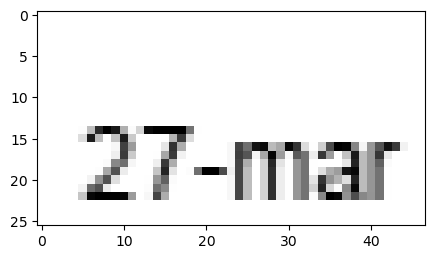

27-mar


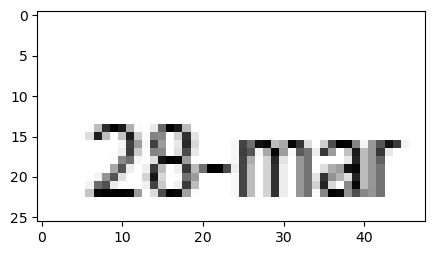

28-mar


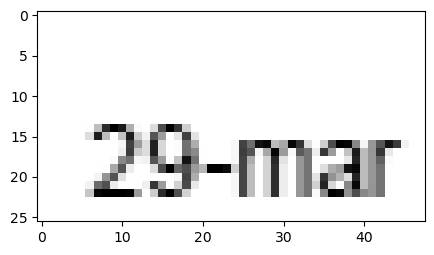

29-mar


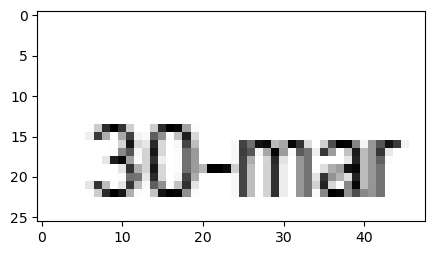

30-mar


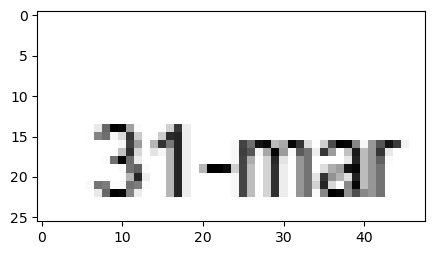

31-mar


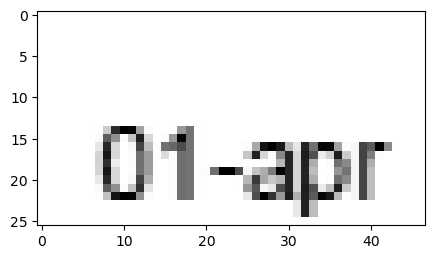

01-apr


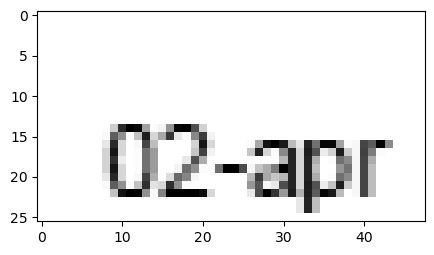

02-apr


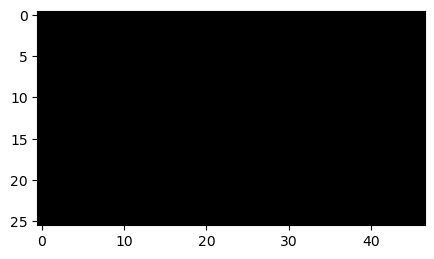

oe


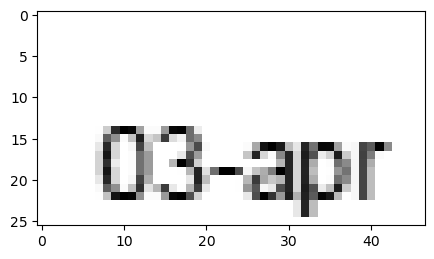

03-apr


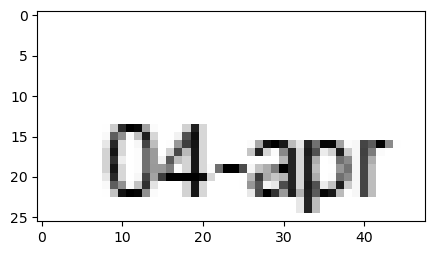

04-apr


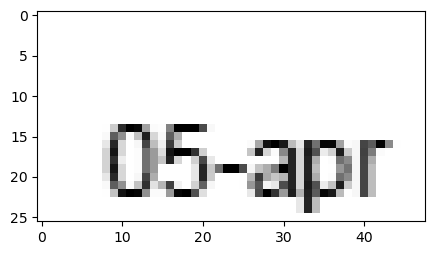

05-apr


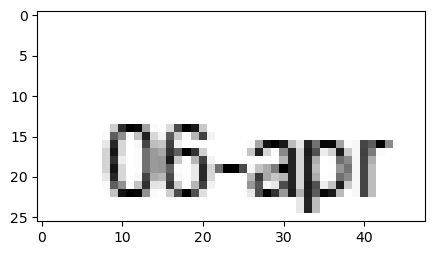

06-apr


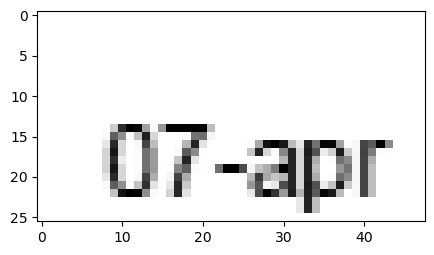

07-apr


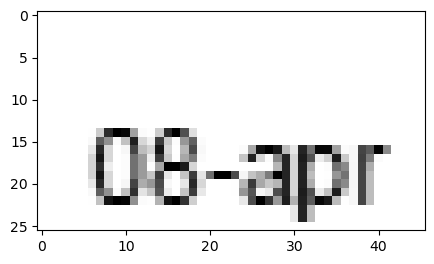

08-apr


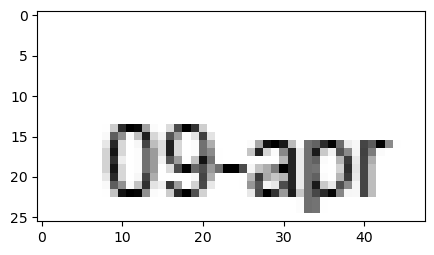

09-apr


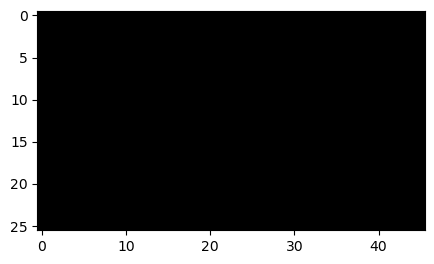

oe


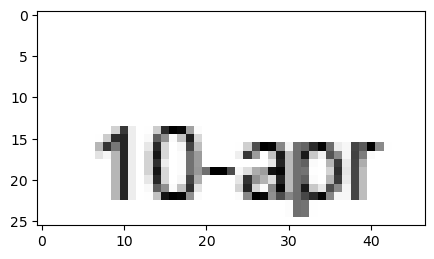

40-apr.


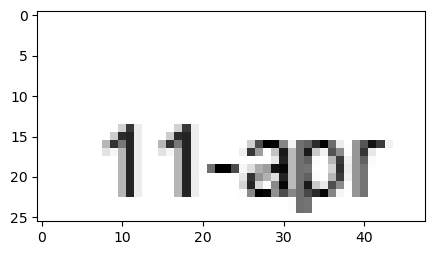

44-apr.


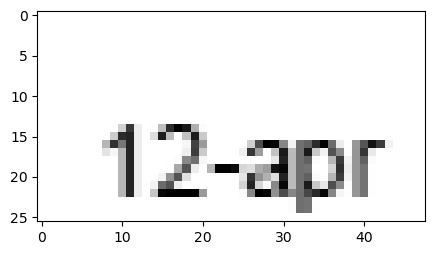

42-apr


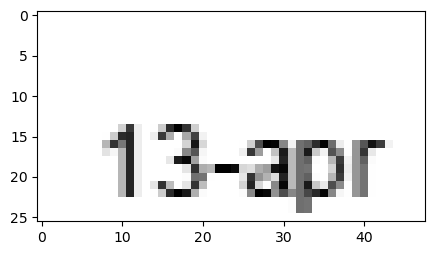

43-apr.


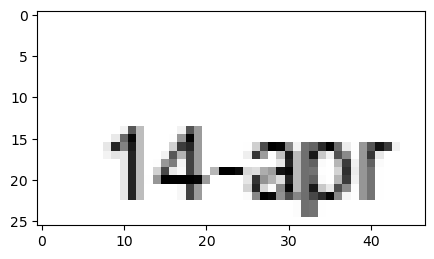

44-apr.


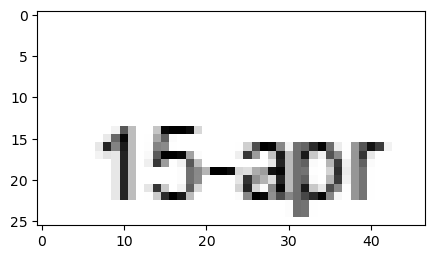

415-apr


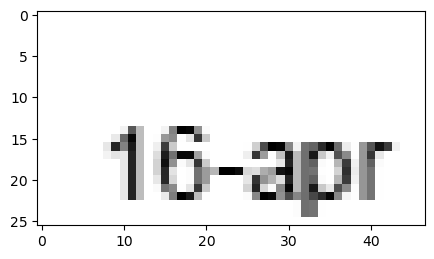

416-apr


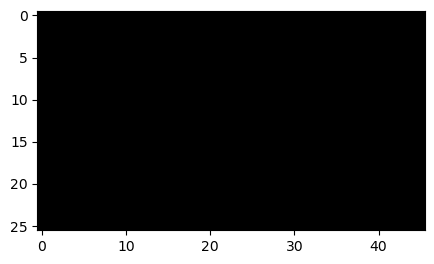

oe


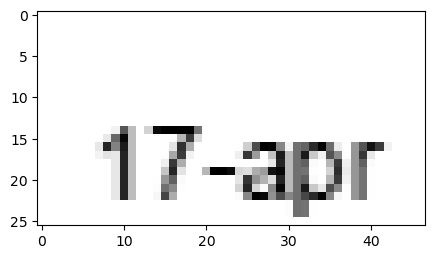

47-apr


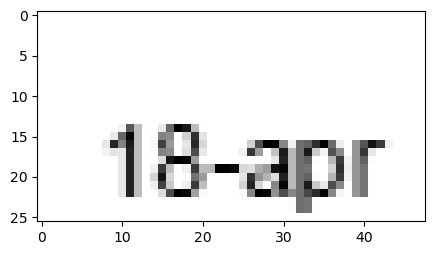

418-apr.


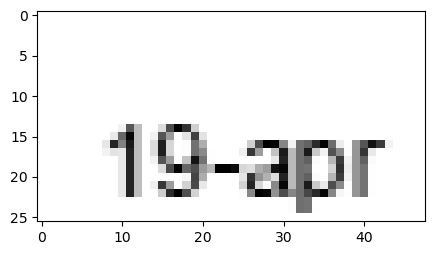

419-apr.


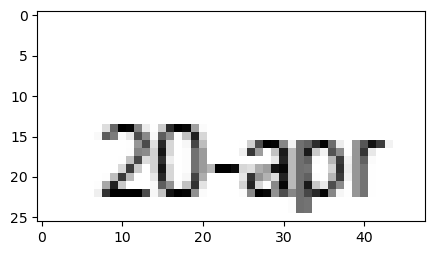

20-apr


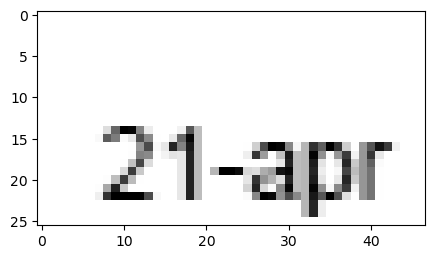

21-apr


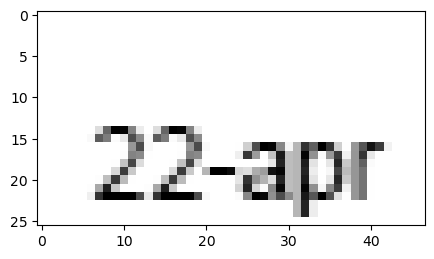

22-apr


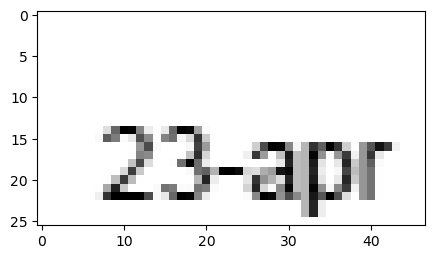

23-apr


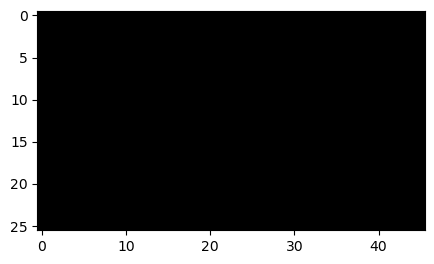

oe


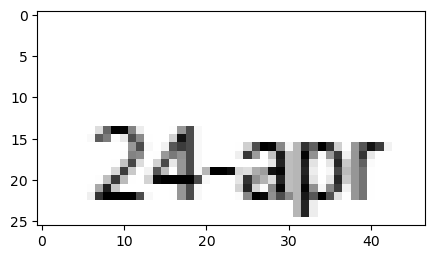

24-apr


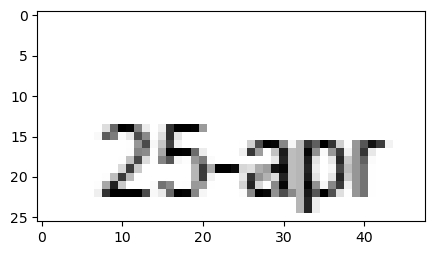

25-apr


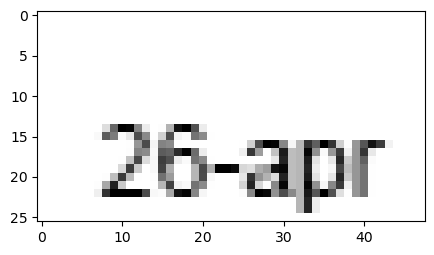

26-apr


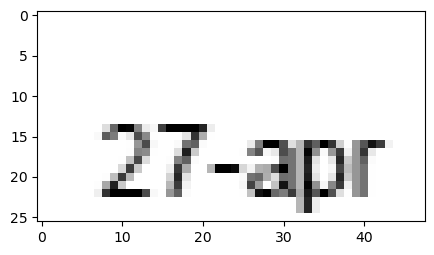

27-apr


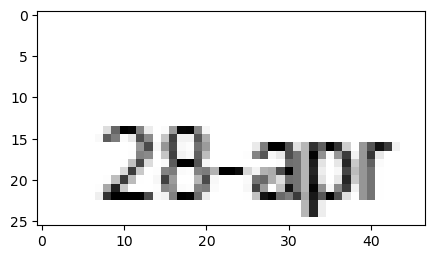

28-apr


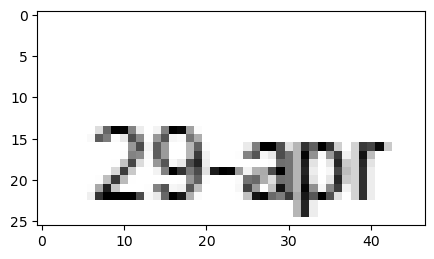

29-apr


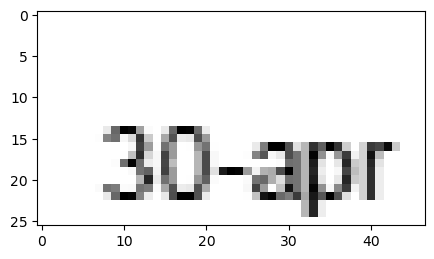

30-apr


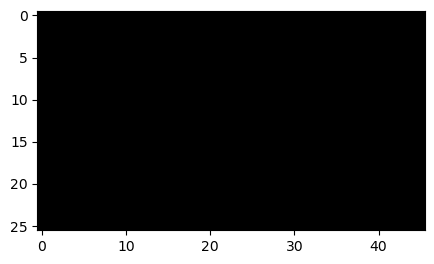

oe


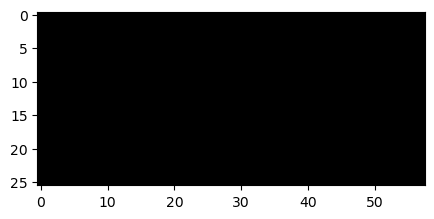

oe


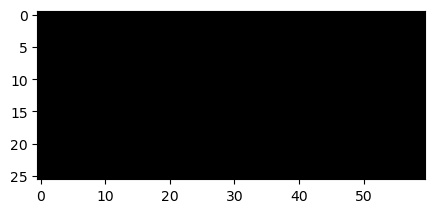

Oo


In [16]:
date_cell_contents = []
for cell in date_cells:
    cell_contents = read_cell(gray_image, cell, print = True)
    date_cell_contents.append(cell_contents)
    print(cell_contents['content'])


In [17]:
date_cell_contents

[{'rect': [(81, 217), (129, 217), (81, 244), (129, 244)], 'content': '27-mar'},
 {'rect': [(130, 217), (179, 217), (130, 244), (179, 244)],
  'content': '28-mar'},
 {'rect': [(180, 217), (229, 217), (180, 244), (229, 244)],
  'content': '29-mar'},
 {'rect': [(230, 217), (279, 217), (230, 244), (279, 244)],
  'content': '30-mar'},
 {'rect': [(280, 217), (329, 217), (280, 244), (329, 244)],
  'content': '31-mar'},
 {'rect': [(331, 217), (379, 217), (331, 244), (379, 244)],
  'content': '01-apr'},
 {'rect': [(380, 217), (429, 217), (380, 244), (429, 244)],
  'content': '02-apr'},
 {'rect': [(431, 217), (479, 217), (431, 244), (479, 244)], 'content': 'oe'},
 {'rect': [(481, 217), (529, 217), (481, 244), (529, 244)],
  'content': '03-apr'},
 {'rect': [(530, 217), (579, 217), (530, 244), (579, 244)],
  'content': '04-apr'},
 {'rect': [(580, 217), (629, 217), (580, 244), (629, 244)],
  'content': '05-apr'},
 {'rect': [(630, 217), (679, 217), (630, 244), (679, 244)],
  'content': '06-apr'},
 {

In [18]:
import re
def remove_empty_cells(cells):
    return [cell for cell in cells if cell['content'].strip() != ""]
def remove_cells_without_dash(cells):
    cells_with_dash = [cell for cell in cells if '-' in cell['content']]
    return cells_with_dash
def fix_cell_dates(cells):
    pattern = re.compile("([0-3][0-9])-(\w{3})")  # Matches 'dd-mmm'

    for i in range(len(cells)):
        # If the current cell content does not match the pattern
        if not pattern.fullmatch(cells[i]['content']):
            # If it's not the first cell
            if i > 0:
                # Get the previous cell's date and increment it
                prev_date_match = pattern.fullmatch(cells[i-1]['content'])

                if prev_date_match:  # if the previous cell's content was a valid date
                    day = int(prev_date_match.group(1))
                    month = prev_date_match.group(2)

                    # Increment the day and reset to 01 if it reaches 32
                    day = day + 1 if day < 31 else 1

                    # Format the day to always have 2 digits
                    day_str = str(day).zfill(2)

                    # Set the current cell's content to the fixed date
                    cells[i]['content'] = f"{day_str}-{month}"

    return cells

# Usage
date_cell_contents_m = remove_empty_cells(date_cell_contents)
date_cell_contents_m = remove_cells_without_dash(date_cell_contents_m)
date_cell_contents_m = fix_cell_dates(date_cell_contents_m)

len(date_cell_contents_m)

date_cell_contents_m

[{'rect': [(81, 217), (129, 217), (81, 244), (129, 244)], 'content': '27-mar'},
 {'rect': [(130, 217), (179, 217), (130, 244), (179, 244)],
  'content': '28-mar'},
 {'rect': [(180, 217), (229, 217), (180, 244), (229, 244)],
  'content': '29-mar'},
 {'rect': [(230, 217), (279, 217), (230, 244), (279, 244)],
  'content': '30-mar'},
 {'rect': [(280, 217), (329, 217), (280, 244), (329, 244)],
  'content': '31-mar'},
 {'rect': [(331, 217), (379, 217), (331, 244), (379, 244)],
  'content': '01-apr'},
 {'rect': [(380, 217), (429, 217), (380, 244), (429, 244)],
  'content': '02-apr'},
 {'rect': [(481, 217), (529, 217), (481, 244), (529, 244)],
  'content': '03-apr'},
 {'rect': [(530, 217), (579, 217), (530, 244), (579, 244)],
  'content': '04-apr'},
 {'rect': [(580, 217), (629, 217), (580, 244), (629, 244)],
  'content': '05-apr'},
 {'rect': [(630, 217), (679, 217), (630, 244), (679, 244)],
  'content': '06-apr'},
 {'rect': [(680, 217), (729, 217), (680, 244), (729, 244)],
  'content': '07-apr

In [19]:
def retrieve_cells_by_content(cells, content):
    matched_cells = []

    for cell in cells:
        if str(content) in cell['content']:
            matched_cells.append(cell)

    return matched_cells

sign_cells = retrieve_cells_by_content(all_cell_contents, 'DOF')
sign_cells

[{'rect': [(25, 407), (78, 407), (25, 429), (78, 429)], 'content': 'DOF'}]

In [20]:
def retrieve_cells_by_exact_content(cells, content):
    matched_cells = []

    for cell in cells:
        if str(content) == cell['content']:
            matched_cells.append(cell)

    return matched_cells

no_cells = retrieve_cells_by_exact_content(all_cell_contents, '6')
no_cells

[]

In [21]:
def read_until_sign_and_date(image, cells, sign):
    all_cell_contents = []
    sign_found = False
    date_found = False

    for cell in cells:
        # Read the cell and append its contents to the list
        cell_content = read_cell(image, cell)
        all_cell_contents.append(cell_content)

        # Check cell content for "sign" and the date regex
        if sign.lower() in cell_content['content'].lower():
            sign_found = True
        elif re.match(r"\b(0[1-9]|1[0-9]|2[0-9]|3[0-1])-(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b", cell_content['content'].lower()):
            date_found = True

        # If both "sign" and a date have been found, stop reading cells
        if sign_found and date_found:
            break

    return all_cell_contents


sign_and_date_cells = read_until_sign_and_date(gray_image, cells_filtered, 'DOF')
sign_and_date_cells

[{'rect': [(25, 31), (78, 31), (25, 155), (78, 155)], 'content': 'L'},
 {'rect': [(25, 158), (78, 158), (25, 186), (78, 186)], 'content': 'Oo'},
 {'rect': [(25, 189), (78, 189), (25, 216), (78, 216)], 'content': 'Sign'},
 {'rect': [(25, 217), (78, 217), (25, 244), (78, 244)], 'content': 'Dat'},
 {'rect': [(25, 247), (78, 247), (25, 268), (78, 268)], 'content': 'AVI'},
 {'rect': [(25, 269), (78, 269), (25, 291), (78, 291)], 'content': 'ARO'},
 {'rect': [(25, 292), (78, 292), (25, 314), (78, 314)], 'content': 'PAC'},
 {'rect': [(25, 315), (78, 315), (25, 336), (78, 336)], 'content': 'ENG'},
 {'rect': [(25, 339), (78, 339), (25, 359), (78, 359)], 'content': 'a'},
 {'rect': [(25, 362), (78, 362), (25, 383), (78, 383)], 'content': 'LNG'},
 {'rect': [(25, 384), (78, 384), (25, 406), (78, 406)], 'content': 'BRO'},
 {'rect': [(25, 407), (78, 407), (25, 429), (78, 429)], 'content': 'DOF'},
 {'rect': [(25, 430), (78, 430), (25, 452), (78, 452)], 'content': 'HOM'},
 {'rect': [(25, 453), (78, 453)

In [22]:
sign_cell=retrieve_cells_by_content(sign_and_date_cells, "DOF")[-1]
sign_cell

{'rect': [(25, 407), (78, 407), (25, 429), (78, 429)], 'content': 'DOF'}

In [23]:
date_cell = sign_and_date_cells[-1]
date_cell

{'rect': [(81, 217), (129, 217), (81, 244), (129, 244)], 'content': '27-mar'}

In [24]:
date_cells = get_cells_on_row(cells_filtered, date_cell['rect'])
date_cells

[[(25, 217), (78, 217), (25, 244), (78, 244)],
 [(130, 217), (179, 217), (130, 244), (179, 244)],
 [(180, 217), (229, 217), (180, 244), (229, 244)],
 [(230, 217), (279, 217), (230, 244), (279, 244)],
 [(280, 217), (329, 217), (280, 244), (329, 244)],
 [(331, 217), (379, 217), (331, 244), (379, 244)],
 [(380, 217), (429, 217), (380, 244), (429, 244)],
 [(431, 217), (479, 217), (431, 244), (479, 244)],
 [(481, 217), (529, 217), (481, 244), (529, 244)],
 [(530, 217), (579, 217), (530, 244), (579, 244)],
 [(580, 217), (629, 217), (580, 244), (629, 244)],
 [(630, 217), (679, 217), (630, 244), (679, 244)],
 [(680, 217), (729, 217), (680, 244), (729, 244)],
 [(732, 217), (779, 217), (732, 244), (779, 244)],
 [(780, 217), (829, 217), (780, 244), (829, 244)],
 [(832, 217), (879, 217), (832, 244), (879, 244)],
 [(882, 217), (930, 217), (882, 244), (930, 244)],
 [(931, 217), (980, 217), (931, 244), (980, 244)],
 [(981, 217), (1030, 217), (981, 244), (1030, 244)],
 [(1031, 217), (1080, 217), (1031

In [25]:
date_cells_read = []
for cell in date_cells:
    cell_dic = read_cell(gray_image,cell)
    date_cells_read.append(cell_dic)

date_cells_filtered = remove_empty_cells(date_cells_read)
date_cells_filtered = remove_cells_without_dash(date_cells_filtered)
date_cells_filtered = fix_cell_dates(date_cells_filtered)
date_cells_filtered

[{'rect': [(130, 217), (179, 217), (130, 244), (179, 244)],
  'content': '28-mar'},
 {'rect': [(180, 217), (229, 217), (180, 244), (229, 244)],
  'content': '29-mar'},
 {'rect': [(230, 217), (279, 217), (230, 244), (279, 244)],
  'content': '30-mar'},
 {'rect': [(280, 217), (329, 217), (280, 244), (329, 244)],
  'content': '31-mar'},
 {'rect': [(331, 217), (379, 217), (331, 244), (379, 244)],
  'content': '01-apr'},
 {'rect': [(380, 217), (429, 217), (380, 244), (429, 244)],
  'content': '02-apr'},
 {'rect': [(481, 217), (529, 217), (481, 244), (529, 244)],
  'content': '03-apr'},
 {'rect': [(530, 217), (579, 217), (530, 244), (579, 244)],
  'content': '04-apr'},
 {'rect': [(580, 217), (629, 217), (580, 244), (629, 244)],
  'content': '05-apr'},
 {'rect': [(630, 217), (679, 217), (630, 244), (679, 244)],
  'content': '06-apr'},
 {'rect': [(680, 217), (729, 217), (680, 244), (729, 244)],
  'content': '07-apr'},
 {'rect': [(732, 217), (779, 217), (732, 244), (779, 244)],
  'content': '08

In [26]:
sign_row = get_cells_on_row(cells_filtered, sign_cell['rect'])
sign_row

[[(81, 407), (129, 407), (81, 429), (129, 429)],
 [(130, 407), (179, 407), (130, 429), (179, 429)],
 [(180, 407), (229, 407), (180, 429), (229, 429)],
 [(230, 407), (279, 407), (230, 429), (279, 429)],
 [(280, 407), (329, 407), (280, 429), (329, 429)],
 [(331, 407), (379, 407), (331, 429), (379, 429)],
 [(380, 407), (429, 407), (380, 429), (429, 429)],
 [(431, 407), (479, 407), (431, 429), (479, 429)],
 [(481, 407), (529, 407), (481, 429), (529, 429)],
 [(530, 407), (579, 407), (530, 429), (579, 429)],
 [(580, 407), (629, 407), (580, 429), (629, 429)],
 [(630, 407), (679, 407), (630, 429), (679, 429)],
 [(680, 407), (729, 407), (680, 429), (729, 429)],
 [(732, 407), (779, 407), (732, 429), (779, 429)],
 [(780, 407), (829, 407), (780, 429), (829, 429)],
 [(832, 407), (879, 407), (832, 429), (879, 429)],
 [(882, 407), (930, 407), (882, 429), (930, 429)],
 [(931, 407), (980, 407), (931, 429), (980, 429)],
 [(981, 407), (1030, 407), (981, 429), (1030, 429)],
 [(1031, 407), (1080, 407), (10

In [27]:
#Stores the content of all the cells in the signature row
sign_row_read = []
for cell in sign_row:
    cell_dic = read_cell(gray_image,cell, 'digit')
    sign_row_read.append(cell_dic)
sign_row_read

[{'rect': [(81, 407), (129, 407), (81, 429), (129, 429)], 'content': '9'},
 {'rect': [(130, 407), (179, 407), (130, 429), (179, 429)], 'content': '9'},
 {'rect': [(180, 407), (229, 407), (180, 429), (229, 429)], 'content': '9'},
 {'rect': [(230, 407), (279, 407), (230, 429), (279, 429)], 'content': '20'},
 {'rect': [(280, 407), (329, 407), (280, 429), (329, 429)],
  'content': 'HINDIII'},
 {'rect': [(331, 407), (379, 407), (331, 429), (379, 429)],
  'content': 'empty'},
 {'rect': [(380, 407), (429, 407), (380, 429), (429, 429)],
  'content': 'empty'},
 {'rect': [(431, 407), (479, 407), (431, 429), (479, 429)],
  'content': '40:00'},
 {'rect': [(481, 407), (529, 407), (481, 429), (529, 429)], 'content': '9'},
 {'rect': [(530, 407), (579, 407), (530, 429), (579, 429)], 'content': '9'},
 {'rect': [(580, 407), (629, 407), (580, 429), (629, 429)], 'content': '9'},
 {'rect': [(630, 407), (679, 407), (630, 429), (679, 429)], 'content': '0'},
 {'rect': [(680, 407), (729, 407), (680, 429), (729

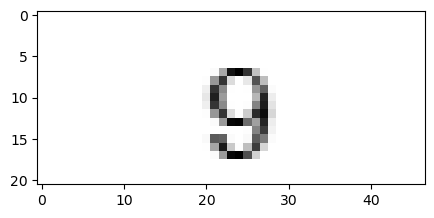

9


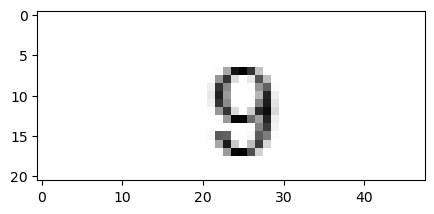

9


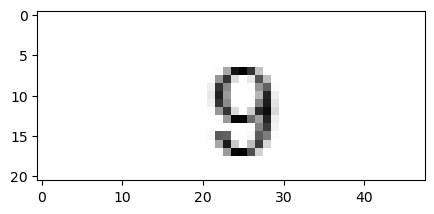

9


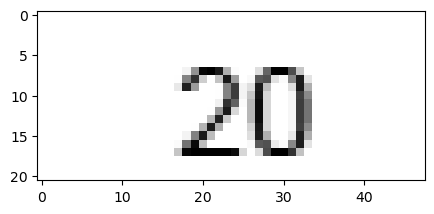

20


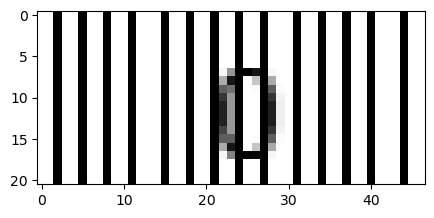

HINDIII


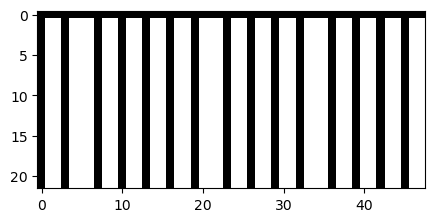

empty


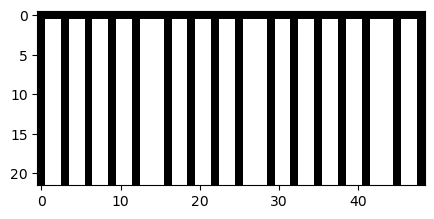

empty


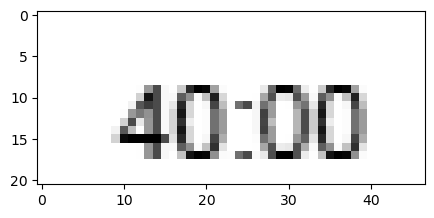

40:00


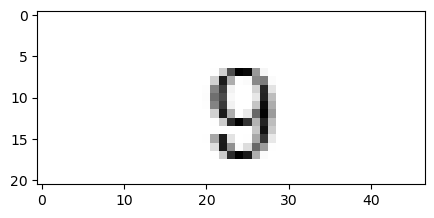

9


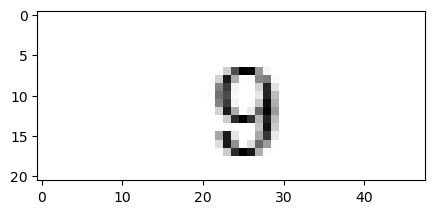

9


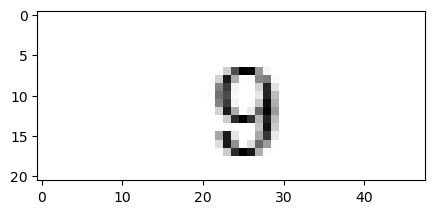

9


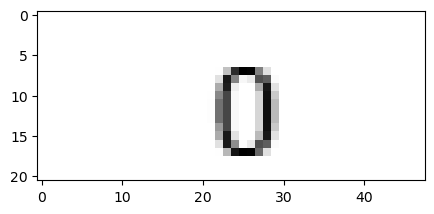

0


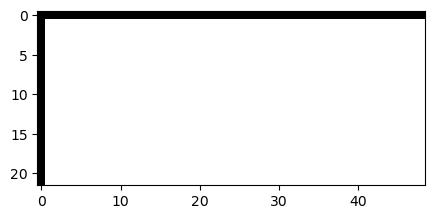

empty


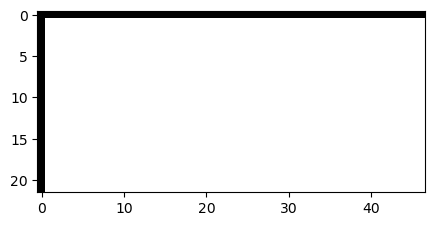

empty


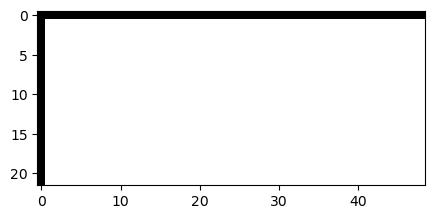

empty


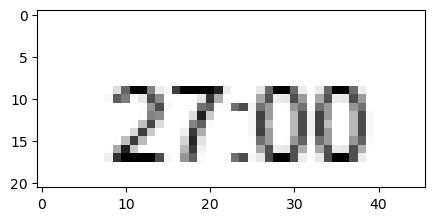

27:00


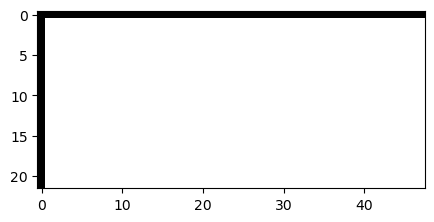

empty


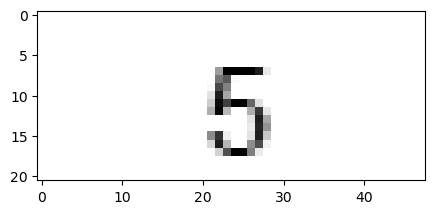

5


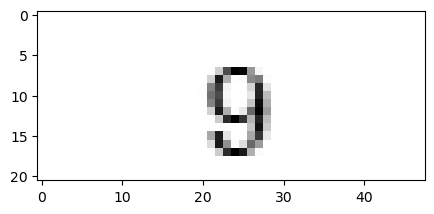

9


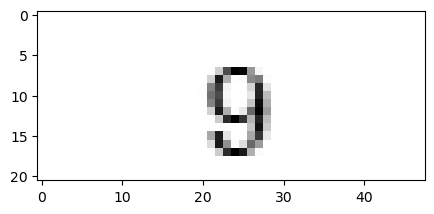

9


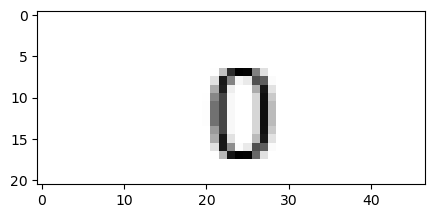

0


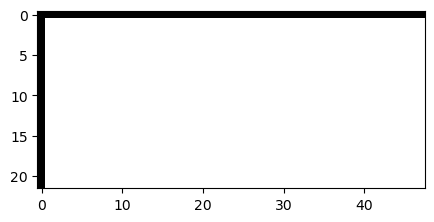

empty


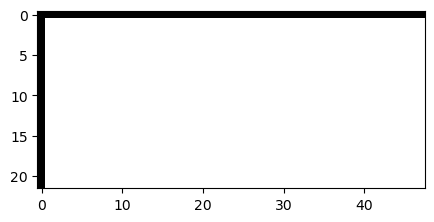

empty


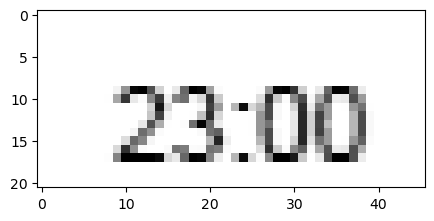

23:00


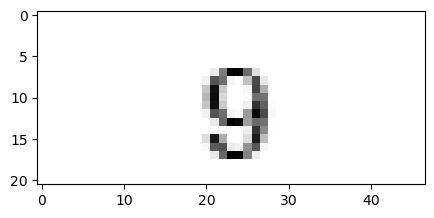

9


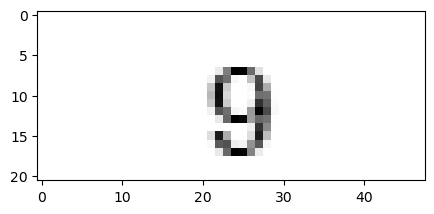

9


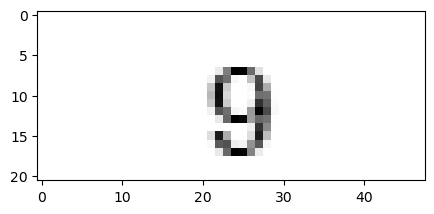

9


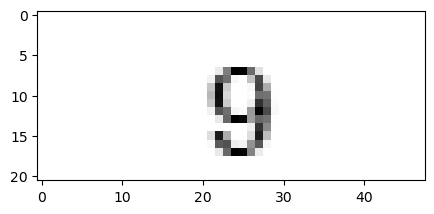

9


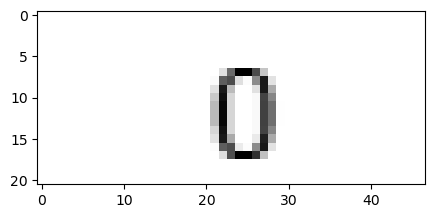

0


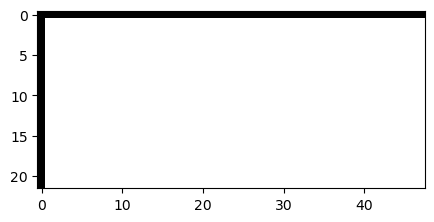

empty


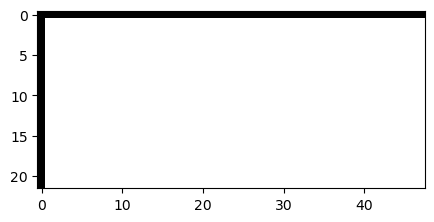

empty


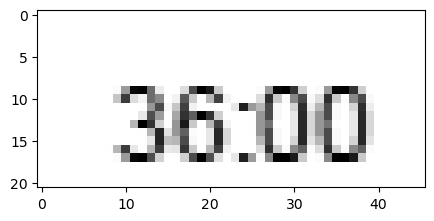

36:00


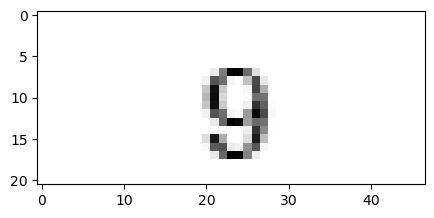

9


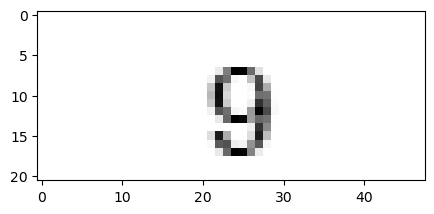

9


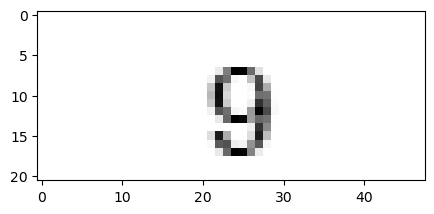

9


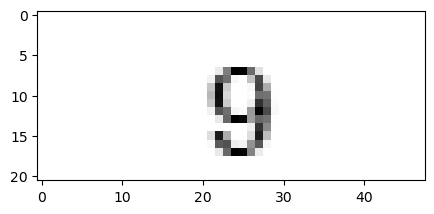

9


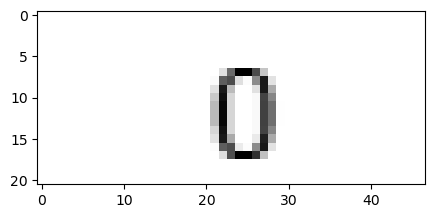

0


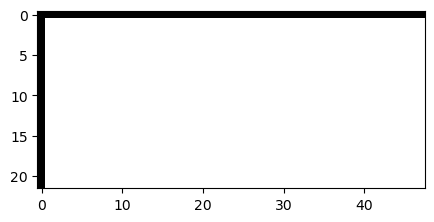

empty


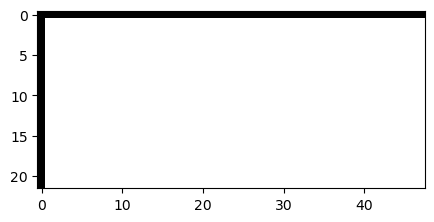

empty


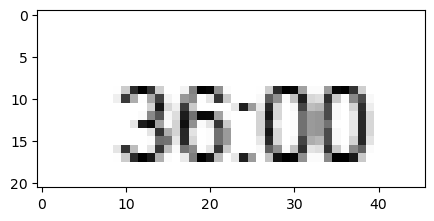

36:00


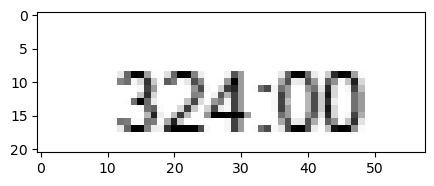

324-00


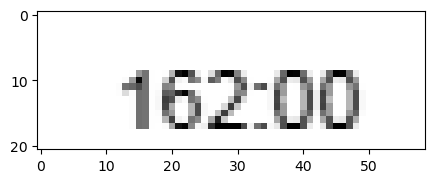

162-00


In [28]:
for cell in sign_row:
    cell_contents = read_cell(gray_image, cell, 'digit', print = True)
    date_cell_contents.append(cell_contents)
    print(cell_contents['content'])


In [29]:
#Stores a set with all the unique number values of the row corresponding the signature
unique_numbers_in_row = set()
for cell in sign_row_read:
    content = cell['content']
    if content.isdigit() and len(content) <= 2 and int(content) >0:
        unique_numbers_in_row.add(int(content))
unique_numbers_in_row


{5, 9, 20}

In [30]:
def get_hours_keys(unique_numbers_in_row, cells_filtered):
    # Definingthe start of the lower 40% of the page
    lower_40_threshold = color_image.shape[0] * 0.6

    # Copy your set of numbers so you can modify it while iterating
    numbers_to_find = unique_numbers_in_row.copy()

    # Create an empty list to store the cell contents
    cell_contents_hours_key = []

    # Iterate over cells
    for cell in cells_filtered:
        # Get the 'y' attribute as the vertical position
        y_position = max(coord[1] for coord in cell)

        # Check if the cell is in the lower 40% of the image
        if y_position >= lower_40_threshold:

            # Read cell and get the content
            cell_content = read_cell(gray_image,cell, 'digit', False)
            text = cell_content['content']
            # If the cell_content is a digit and is in our numbers_to_find
            if text.isdigit() and int(text) in numbers_to_find:
                # Add cell content to our list
                cell_contents_hours_key.append(cell_content)

                # Remove the found number from our set
                numbers_to_find.remove(int(text))
            # If we have found all numbers, break the loop
            if len(numbers_to_find) == 0:
                break
    return cell_contents_hours_key
cell_contents_hours_key = get_hours_keys(unique_numbers_in_row, cells_filtered)

5
9
20


In [33]:
cell_contents_hours_key

[{'rect': [(81, 997), (129, 997), (81, 1026), (129, 1026)], 'content': '5'},
 {'rect': [(81, 1126), (129, 1126), (81, 1155), (129, 1155)], 'content': '9'},
 {'rect': [(481, 1158), (529, 1158), (481, 1188), (529, 1188)],
  'content': '20'}]

In [34]:
def get_list_of_working_hours(cell_contents_hours_key, cells_filtered):
    working_hours_list = []
    for cell in cell_contents_hours_key:
        dic = {}
        dic['work_key'] = cell['content']
        dic['hours'] = []
        cells_to_right = get_cells_on_row(cells_filtered, cell['rect'], only_right=True)
        for subcell in cells_to_right[:6]:
            subcell_content = read_cell(gray_image, subcell, type = 'digit', print = False)
            matches = re.findall(r"\b\d{1,2}[:-]\d{2}\b", subcell_content['content'])
            if matches: dic['hours'].extend(matches)  # extend the list with new matches
        working_hours_list.append(dic)
    return working_hours_list
working_hours_list = get_list_of_working_hours(cell_contents_hours_key, cells_filtered)
working_hours_list

[{'work_key': '5', 'hours': ['7:30', '12:30']},
 {'work_key': '9', 'hours': ['7:30', '16:30']},
 {'work_key': '20', 'hours': ['10:00', '23:00']}]

In [35]:
def get_mid_x(rect):
    """Get middle x-point of a rectangle"""
    x_left = rect[0][0]
    x_right = rect[2][0]
    return (x_left + x_right) / 2

def find_corresponding_cell(mid_x, sign_row_read):
    """Find the corresponding cell in sign_row_read that has mid_x within its x range"""
    for cell in sign_row_read:
        x_left = cell['rect'][0][0]
        x_right = cell['rect'][2][0]
        if x_left <= mid_x <= x_right:
            return cell
    return None

def combine_date_and_work_key(date_cells_filtered, sign_row_read):
    result_list = []

    for date_cell in date_cells_filtered:
        mid_x = get_mid_x(date_cell['rect'])
        corresponding_cell = find_corresponding_cell(mid_x, sign_row_read)

        if corresponding_cell is not None:
            result_list.append({'date': date_cell['content'], 'work_hours': corresponding_cell['content']})
    return result_list

date_work_key_dics = combine_date_and_work_key(date_cells_filtered, sign_row_read)
date_work_key_dics


[{'date': '28-mar', 'work_hours': '9'},
 {'date': '29-mar', 'work_hours': '9'},
 {'date': '30-mar', 'work_hours': '20'},
 {'date': '31-mar', 'work_hours': 'HINDIII'},
 {'date': '01-apr', 'work_hours': 'empty'},
 {'date': '02-apr', 'work_hours': 'empty'},
 {'date': '03-apr', 'work_hours': '9'},
 {'date': '04-apr', 'work_hours': '9'},
 {'date': '05-apr', 'work_hours': '9'},
 {'date': '06-apr', 'work_hours': '0'},
 {'date': '07-apr', 'work_hours': 'empty'},
 {'date': '08-apr', 'work_hours': 'empty'},
 {'date': '09-apr', 'work_hours': 'empty'},
 {'date': '10-apr', 'work_hours': 'empty'},
 {'date': '11-apr', 'work_hours': '5'},
 {'date': '12-apr', 'work_hours': '9'},
 {'date': '13-apr', 'work_hours': '9'},
 {'date': '14-apr', 'work_hours': '0'},
 {'date': '15-apr', 'work_hours': 'empty'},
 {'date': '16-apr', 'work_hours': 'empty'},
 {'date': '17-apr', 'work_hours': '9'},
 {'date': '18-apr', 'work_hours': '9'},
 {'date': '19-apr', 'work_hours': '9'},
 {'date': '20-apr', 'work_hours': '9'},
 